# 13. Json City Similarities

In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from platform import python_version
print(python_version())

3.6.10


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Load Dataset


In [15]:
def parse_json(data):
    """ function to parse json data """
    session_id = []
    timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []
    
    # parse each item
    for item in data:
        session_id.append(item['session_id'][0])
        timestamp.append(item['unix_timestamp'][0])
        cities.append(item['cities'][0])
        user_id.append(item['user'][0][0]['user_id'])
        joining_date.append(item['user'][0][0]['joining_date'])
        country.append(item['user'][0][0]['country'])
    
    # create DataFrame
    maps = {'session_id': session_id, 'timestamp': timestamp, 'cities': cities, 
            'user_id': user_id, 'joining_date': joining_date, 'country': country}
    columns=['session_id', 'timestamp', 'cities', 'user_id', 'joining_date', 'country']
    
    return pd.DataFrame(maps, columns=columns)

In [16]:
with open('E:/Collection_DS_takehome_challenges/Data/city_searches.json', 'r') as f:
    json_data = json.load(f)
    
data = parse_json(json_data)
data['joining_date'] = pd.to_datetime(data['joining_date'])
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   session_id    20022 non-null  object        
 1   timestamp     20022 non-null  int64         
 2   cities        20022 non-null  object        
 3   user_id       20022 non-null  int64         
 4   joining_date  20022 non-null  datetime64[ns]
 5   country       20022 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 938.7+ KB


In [38]:
for column in list(data.columns):
    num=data[data[column] == ''][column].count()
    print(column,'blank : \t',num)

session_id blank : 	 0
timestamp blank : 	 0
cities blank : 	 0
user_id blank : 	 0
joining_date blank : 	 0
country blank : 	 2769


In [39]:
print('Unique session:\t', len(data['session_id'].unique()))
print('Unique users \t', len(data['user_id'].unique()))

Unique session:	 20022
Unique users 	 9252


## Questions1

In [ ]:
# check the value country
data['country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'count'})

In [53]:
# check the value country
data.groupby('country')['session_id'].count().reset_index().rename(columns={'country': 'country', 'session_id': 'count'}).sort_values('count',ascending=False)

,country,count
6,US,3772
5,UK,3754
1,DE,3741
0,,2769
3,FR,2341
4,IT,1843
2,ES,1802


Given the current dataset, since there are little information about the dataset, one information that could be used to guess the country is the search time. Since people in different countries will search in similar local time, we can use this information to guess the country.

In [57]:
data[data['country']==''].head()

,session_id,timestamp,cities,user_id,joining_date,country
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
8,FHDJFT27R46XS,1431161158,New York NY,7146,2015-03-21,
10,4Z4AWQGLY2D35,1432207705,Los Angeles CA,3845,2015-03-12,
14,MPVIM7WTAHT91,1438144462,"New York NY, Toronto ON",8469,2015-03-29,
15,QIZD4OG4SFW70,1426410726,New York NY,9184,2015-03-08,


In [58]:
# extract search time information
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['time'].apply(lambda x: x.hour)

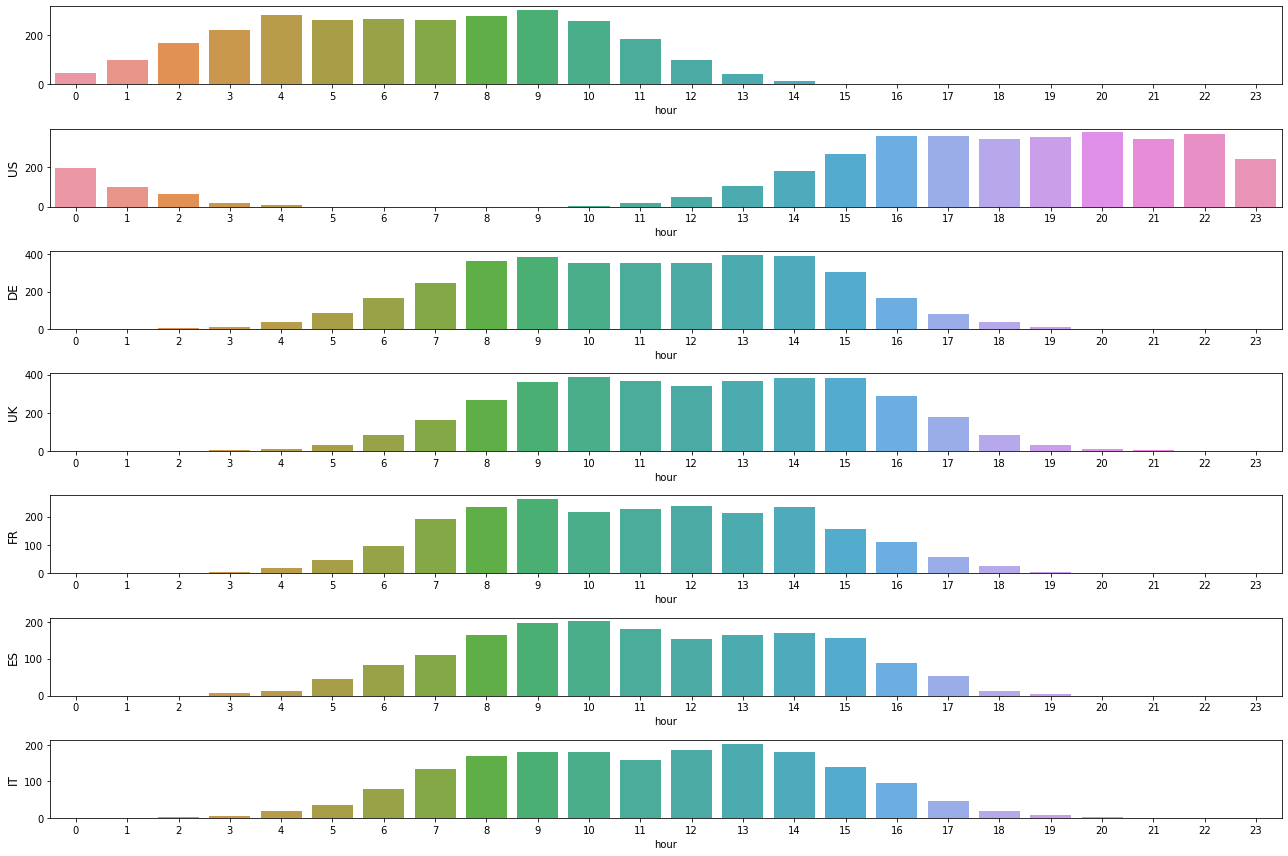

In [61]:
# visualization
country_list = ['','US', 'DE', 'UK', 'FR', 'ES', 'IT']
order = list(range(0, 24))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

Based on above figure, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in Asia. Possible countries include China and Japan.

## Question 2

For each city, find the most likely city to be also searched for within the same session.

In [62]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country,time,hour
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19


In [65]:
city_pair = data['cities'].str.split(', ')
print(city_pair)

0             [San Jose CA, Montreal QC]
1                          [New York NY]
2               [Montreal QC, Quebec QC]
3                           [Chicago IL]
4               [Toronto ON, Houston TX]
                      ...               
20017                       [Phoenix AZ]
20018                        [OTTAWA ON]
20019                  [Indianapolis IN]
20020                       [Chicago IL]
20021    [Los Angeles CA, Long Beach CA]
Name: cities, Length: 20022, dtype: object


In [67]:
city_pair = data['cities'].apply(lambda x: x.split(', '))
print(city_pair)

0             [San Jose CA, Montreal QC]
1                          [New York NY]
2               [Montreal QC, Quebec QC]
3                           [Chicago IL]
4               [Toronto ON, Houston TX]
                      ...               
20017                       [Phoenix AZ]
20018                        [OTTAWA ON]
20019                  [Indianapolis IN]
20020                       [Chicago IL]
20021    [Los Angeles CA, Long Beach CA]
Name: cities, Length: 20022, dtype: object


In [103]:
city_pair_list =[]
for x in city_pair:
    city_pair_list.extend(x)
    

print(len(city_pair_list))
print(len(list(set(city_pair_list))))

33071
87


In [118]:
index = 0
maps = {}
city_list = []
for item in city_pair:
    for city in item:
        if city not in maps:
            maps[city] = index
            index += 1
            city_list.append(city)
            
print('Unique cities:\t', len(city_list))
print(city_list)

Unique cities:	 87
['San Jose CA', 'Montreal QC', 'New York NY', 'Quebec QC', 'Chicago IL', 'Toronto ON', 'Houston TX', 'Los Angeles CA', 'San Diego CA', 'Santa Ana CA', 'Saint Catharines-Niagara ON', 'Edmonton AB', 'Philadelphia PA', 'Vancouver BC', 'Detroit MI', 'Phoenix AZ', 'Calgary AB', 'Jersey City NJ', 'Newark NJ', 'Columbus OH', 'Portland OR', 'Austin TX', 'Boston MA', 'Buffalo NY', 'Anaheim CA', 'Indianapolis IN', 'OTTAWA ON', 'Riverside CA', 'Long Beach CA', 'Toledo OH', 'San Antonio TX', 'Jacksonville FL', 'Baltimore MD', 'Hamilton ON', 'Seattle WA', 'Victoria BC', 'Corpus Christi TX', 'Miami FL', 'Hialeah FL', 'Saint Petersburg FL', 'Tampa FL', 'Glendale AZ', 'Milwaukee WI', 'Madison WI', 'Dallas TX', 'WASHINGTON DC', 'Stockton CA', 'San Francisco CA', 'Oshawa ON', 'Arlington TX', 'Chandler AZ', 'Louisville KY', 'Plano TX', 'Mesa AZ', 'Kitchener ON', 'Cincinnati OH', 'Chesapeake VA', 'Virginia Beach VA', 'Lexington KY', 'Fort Worth TX', 'Sacramento CA', 'Oakland CA', 'Fresn

In [110]:
# calculate matrix similarity
pair_matrix = np.zeros((87, 87))

for item in city_pair:
    if len(item) == 1:
        continue
    for i in range(len(item) - 1):
        index1 = maps[item[i]]
        for j in range(i + 1, len(item)):
            index2 = maps[item[j]]
            pair_matrix[index1, index2] += 1
            pair_matrix[index2, index1] += 1

In [111]:
# create dataframe
df_similarity = pd.DataFrame(pair_matrix, index=city_list, columns=city_list)
df_similarity.head()

,San Jose CA,Montreal QC,New York NY,Quebec QC,Chicago IL,Toronto ON,Houston TX,Los Angeles CA,San Diego CA,Santa Ana CA,...,Norfolk VA,Atlanta GA,Charlotte NC,Raleigh NC,Lincoln NE,Omaha NE,Kansas City MO,Birmingham AL,Minneapolis MN,Memphis TN
San Jose CA,0.0,17.0,40.0,0.0,12.0,25.0,7.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Montreal QC,17.0,0.0,339.0,111.0,101.0,254.0,77.0,154.0,18.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New York NY,40.0,339.0,0.0,7.0,260.0,427.0,172.0,318.0,62.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quebec QC,0.0,111.0,7.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicago IL,12.0,101.0,260.0,0.0,0.0,145.0,74.0,116.0,20.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,12.0,0.0


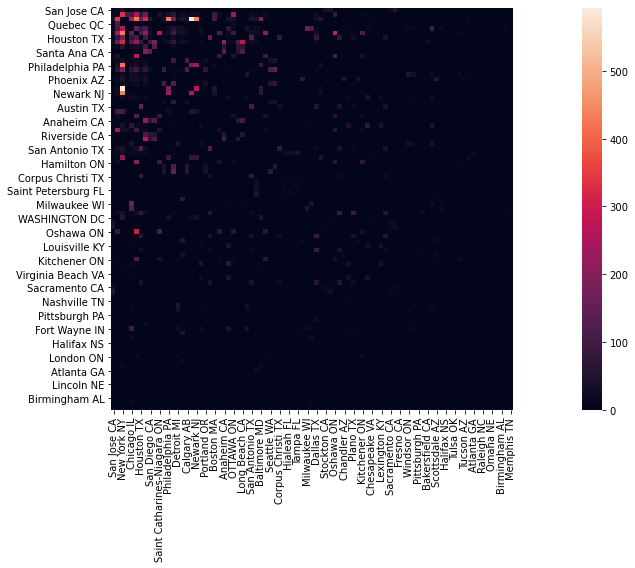

In [113]:
# visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_similarity, ax=ax)
ax.axis('image')
plt.tight_layout()
plt.show()

In [133]:
# get result
result = df_similarity.apply(np.argmax, axis=0).reset_index()
result = result.rename(columns={'index': 'city', 0: 'Index'})
print(result)

city_list2 = pd.DataFrame(city_list,columns=['most similar'])
print(city_list2)

city_list2 = city_list2.reset_index().rename(columns={'index': 'Index'})
df = pd.merge(left=result, right=city_list2, on='Index', how='left')
df.drop(columns=['Index'],inplace=True)

df.head(20)

              city  Index
0      San Jose CA     61
1      Montreal QC      2
2      New York NY     17
3        Quebec QC      1
4       Chicago IL      2
..             ...    ...
82        Omaha NE      4
83  Kansas City MO     44
84   Birmingham AL     31
85  Minneapolis MN      4
86      Memphis TN     19

[87 rows x 2 columns]
      most similar
0      San Jose CA
1      Montreal QC
2      New York NY
3        Quebec QC
4       Chicago IL
..             ...
82        Omaha NE
83  Kansas City MO
84   Birmingham AL
85  Minneapolis MN
86      Memphis TN

[87 rows x 1 columns]


,city,most similar
0,San Jose CA,Oakland CA
1,Montreal QC,New York NY
2,New York NY,Jersey City NJ
3,Quebec QC,Montreal QC
4,Chicago IL,New York NY
5,Toronto ON,New York NY
6,Houston TX,New York NY
7,Los Angeles CA,New York NY
8,San Diego CA,Santa Ana CA
9,Santa Ana CA,Los Angeles CA


## Question 3

Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

For this question, one way is to actually calculate the geographic distance for actual searched cities. However, this solution is not very practical for this small project. Another choice is to calculate the distance based on the city-city similarity in Question 2.

In [142]:
cities = data['cities'].str.split(', ')
print(cities)

print(range(len(cities)-1))
    


0             [San Jose CA, Montreal QC]
1                          [New York NY]
2               [Montreal QC, Quebec QC]
3                           [Chicago IL]
4               [Toronto ON, Houston TX]
                      ...               
20017                       [Phoenix AZ]
20018                        [OTTAWA ON]
20019                  [Indianapolis IN]
20020                       [Chicago IL]
20021    [Los Angeles CA, Long Beach CA]
Name: cities, Length: 20022, dtype: object
range(0, 20021)


In [147]:
def search_distance(cities):
    cities = cities.split(', ')
    
    if len(cities) == 1:
        return 0  # user only search one city, distance 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i]
        for j in range(i + 1, len(cities)):
            city2 = cities[j]
            distance += df_similarity.loc[city1, city2]    
    return distance / len(cities)
  
# calculate distance
data['distance'] = data['cities'].apply(search_distance)


In [149]:
print(df_similarity)

                San Jose CA  Montreal QC  New York NY  Quebec QC  Chicago IL  \
San Jose CA             0.0         17.0         40.0        0.0        12.0   
Montreal QC            17.0          0.0        339.0      111.0       101.0   
New York NY            40.0        339.0          0.0        7.0       260.0   
Quebec QC               0.0        111.0          7.0        0.0         0.0   
Chicago IL             12.0        101.0        260.0        0.0         0.0   
...                     ...          ...          ...        ...         ...   
Omaha NE                0.0          0.0          0.0        0.0         2.0   
Kansas City MO          0.0          0.0          0.0        0.0         1.0   
Birmingham AL           0.0          0.0          0.0        0.0         0.0   
Minneapolis MN          0.0          0.0          0.0        0.0        12.0   
Memphis TN              0.0          0.0          0.0        0.0         0.0   

                Toronto ON  Houston TX 

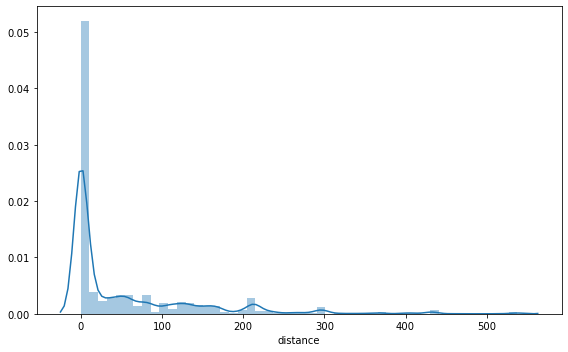

In [148]:
# visualization
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

It seems that we can set some threshold to cut the search distance such that any search that is above the threshold are assumed to be the search with low intent